In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Model

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df['REASON'] = df['REASON'].replace(np.nan, 'NotProvided')
df['JOB'] = df['JOB'].replace(np.nan, 'Other')

In [ ]:
mean_fill_cols = ['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
# lin_reg_cols = ['MORTDUE', 'VALUE']
lin_reg_cols = ['VALUE']

In [ ]:
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
def prune_tree(train_X, train_y, test_X, test_y, aplpha_values):
    best_f1 = 0
    best_tree = None
    for alpha in aplpha_values:
        tree = DecisionTreeClassifier(random_state=8, ccp_alpha=alpha)
        tree.fit(train_X, train_y)
        
        y_pred = tree.predict(test_X)
        f1 = f1_score(y_true=test_y, y_pred=y_pred)
        
        if f1 > best_f1:
            best_f1 = f1
            best_tree = tree
    
    return best_tree

# Standard Model

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)

precision_error = []
recall_error = []
f1_error = []
depth_track = []

precision_error_prune = []
recall_error_prune = []
f1_error_prune = []
depth_track_prune = []

for train_idx, test_idx in kf.split(df):
    train_data = df.iloc[train_idx].copy()
    test_data = df.iloc[test_idx].copy()
    
    # Remove traget variable
    y_train = train_data.pop('BAD')
    y_test = test_data.pop('BAD')
    
    # Fill missing values with mean
    for col in mean_fill_cols:
        mean = train_data[col].mean()
        train_data[col] = train_data[col].fillna(mean)
        test_data[col] = test_data[col].fillna(mean)
    
    # Fill missing values using linear regression (It goes MORTDUE then VALUE as MORTDUE has more missing values)
    for col in lin_reg_cols:
        linear_train_data = train_data.copy()
        linear_test_data = test_data.copy()
        
        # fill VALUE with Mean for the first pass
        if col == 'MORTDUE':
            mean = linear_train_data['VALUE'].mean()
            linear_train_data['VALUE'] = linear_train_data['VALUE'].fillna(mean)
            linear_test_data['VALUE'] = linear_test_data['VALUE'].fillna(mean)
        
        linear_train_data = linear_train_data.dropna()
        
        # Set the scaling to be used
        # standard_scaler_cols = ['LOAN', 'MORTDUE', 'VALUE', 'CLAGE', 'CLNO', 'DEBTINC']
        standard_scaler_cols = ['LOAN', 'VALUE', 'CLAGE', 'CLNO', 'DEBTINC']
        min_max_scaler_cols = ['YOJ', 'DEROG', 'DELINQ', 'NINQ']
        one_hot = ['JOB', 'REASON']
        
        # Only the prediction column is not scaled
        if col in standard_scaler_cols:
            standard_scaler_cols.remove(col)
        
        if col in min_max_scaler_cols:
            min_max_scaler_cols.remove(col)
        
        # Create the process
        preprocessor = ColumnTransformer(
            transformers=[
                ('num_min_max', MinMaxScaler(), min_max_scaler_cols),
                ('num_standard', StandardScaler(), standard_scaler_cols),
                ('cat', OneHotEncoder(), one_hot)
            ]
        )
        # Remove traget variable
        y_linear_train = linear_train_data.pop(col)
        linear_test_data.pop(col)
        
        train_data_transformed = preprocessor.fit_transform(linear_train_data)
        test_data_transformed = preprocessor.transform(linear_test_data)
        
        # Create model
        linear_model = LinearRegression()
        linear_model.fit(train_data_transformed, y_linear_train)

        # Replace the missing values
        replacement_values = []
        
        for i, data in enumerate(test_data_transformed):
            
            if np.isnan(test_data.iloc[i][col]):
                replacement_values.append(linear_model.predict(data.reshape(1, -1))[0])
            else:
                replacement_values.append(test_data.iloc[i][col])
        test_data[col] = replacement_values
    
    
    # For one hot encoding
    # passthrough_col = ['LOAN', 'MORTDUE', 'VALUE', 'CLAGE', 'CLNO', 'DEBTINC', 'YOJ', 'DEROG', 'DELINQ', 'NINQ']
    passthrough_col = ['LOAN', 'VALUE', 'CLAGE', 'DEBTINC', 'DEROG', 'DELINQ', 'NINQ']
    one_hot = ['JOB', 'REASON']
    
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('passthrough', 'passthrough', passthrough_col),
            ('cat', OneHotEncoder(), one_hot)
        ]
    )
    
    
    train_data_transformed = preprocessor.fit_transform(train_data)
    test_data_transformed = preprocessor.transform(test_data)
    
    # Create model (Can play with class weights)
    tree_model = DecisionTreeClassifier(class_weight={0:1, 1:1}, random_state=8)
    tree_model.fit(train_data_transformed, y_train)
    
    y_pred = tree_model.predict(test_data_transformed)
    
    # Get error
    print(f'Before Pruning: precision is {precision_score(y_true=y_test, y_pred=y_pred)}, recall is {recall_score(y_true=y_test, y_pred=y_pred)}, f1 is {f1_score(y_true=y_test, y_pred=y_pred)} Depth is {tree_model.get_depth()}')
    precision_error.append(precision_score(y_true=y_test, y_pred=y_pred))
    recall_error.append(recall_score(y_true=y_test, y_pred=y_pred))
    f1_error.append(f1_score(y_true=y_test, y_pred=y_pred))
    depth_track.append(tree_model.get_depth())
    
    # Prune Tree
    alpha_values = tree_model.cost_complexity_pruning_path(train_data_transformed, y_train).ccp_alphas
    tree_model = prune_tree(train_X=train_data_transformed, train_y=y_train, test_X=test_data_transformed, test_y=y_test, aplpha_values=alpha_values)
    y_pred = tree_model.predict(test_data_transformed)
    print(f'After Pruning: precision is {precision_score(y_true=y_test, y_pred=y_pred)}, recall is {recall_score(y_true=y_test, y_pred=y_pred)}, f1 is {f1_score(y_true=y_test, y_pred=y_pred)} Depth is {tree_model.get_depth()}')
    precision_error_prune.append(precision_score(y_true=y_test, y_pred=y_pred))
    recall_error_prune.append(recall_score(y_true=y_test, y_pred=y_pred))
    f1_error_prune.append(f1_score(y_true=y_test, y_pred=y_pred))
    depth_track_prune.append(tree_model.get_depth())
    
    
    '''# Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), cmap='coolwarm', annot=True, fmt='d')
    plt.show()
    
    # Plot Tree
    feature_names = []
    
    for name in preprocessor.get_feature_names_out():
        feature_names.append(name.split('__')[1])
    
    plt.figure(figsize=(8, 6))
    plot_tree(tree_model, filled=True, feature_names=feature_names, max_depth=4)
    plt.savefig("tree.pdf", format="pdf")
    plt.show()'''

print(f'Mean precision error is {np.mean(precision_error)} Mean recall error is {np.mean(recall_error)}  Mean f1 error is {np.mean(f1_error)} Mean Depth {np.mean(depth_track)}')
print(f'Prune Mean precision error is {np.mean(precision_error_prune)} Mean recall error is {np.mean(recall_error_prune)}  Mean f1 error is {np.mean(f1_error_prune)} Mean Depth {np.mean(depth_track_prune)}')
        
        

In [ ]:
preprocessor.get_feature_names_out()

# Objective One

In [16]:
def get_best_threshold(y_true, y_prob):
    
    best_threshold = 0.5
    
    best_good_recall = 0
    
    thresholds = np.arange(0.01, 1.0, 0.01)
    
    for threshold in thresholds:
        y_preds = (y_prob >= threshold).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel() 
        
        recall_bad = tp / (tp + fn)
        recall_good = tn / (tn + fp)
        
        if recall_bad >= 0.85 and recall_good > best_good_recall:
            best_good_recall = recall_good
            
            best_threshold = threshold
    
    return best_threshold

precision is 0.49271844660194175, recall is 0.8565400843881856, f1 is 0.6255778120184899 Depth is 13
Recall Good: 0.7811518324607329, Recall Bad: 0.7811518324607329, Threshold: 0.08


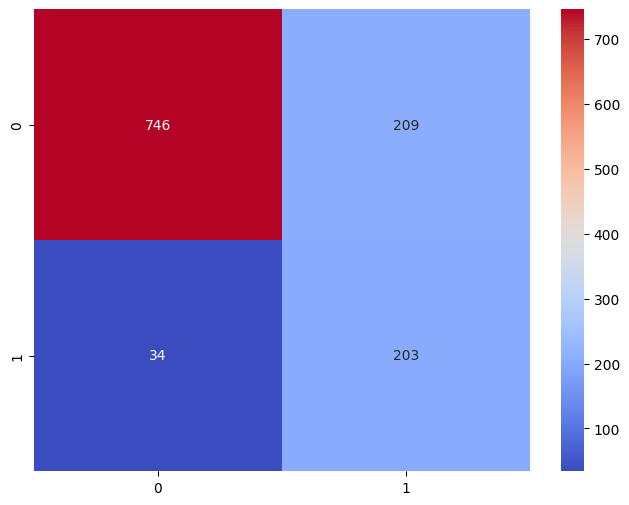

precision is 0.5036319612590799, recall is 0.8188976377952756, f1 is 0.623688155922039 Depth is 6
Recall Good: 0.7814498933901919, Recall Bad: 0.7814498933901919, Threshold: 0.060000000000000005


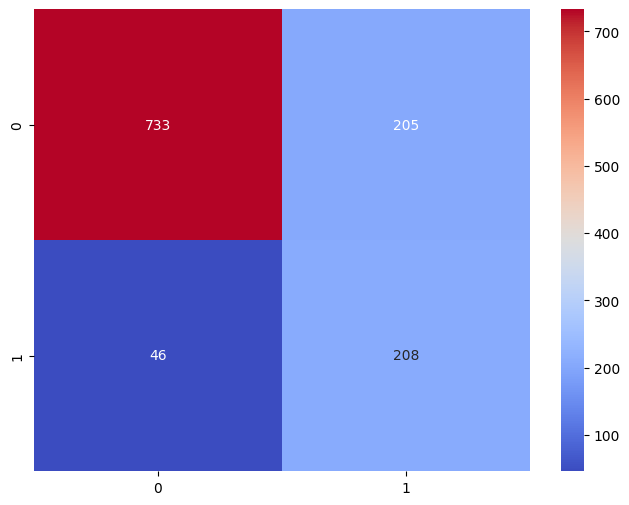

precision is 0.6401515151515151, recall is 0.7681818181818182, f1 is 0.6983471074380165 Depth is 18
Recall Good: 0.9022633744855967, Recall Bad: 0.9022633744855967, Threshold: 0.17


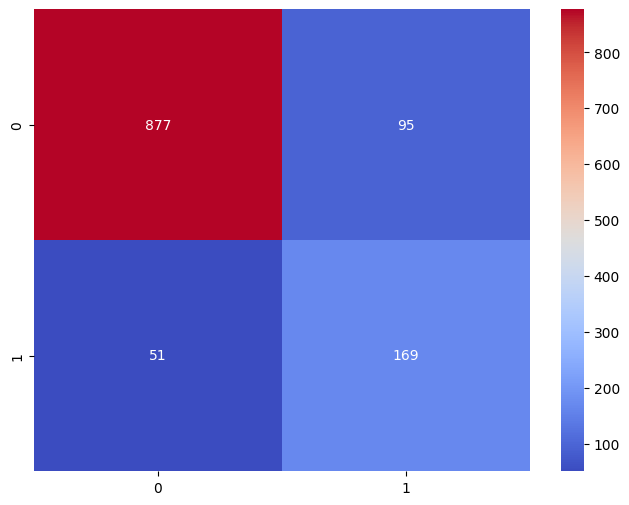

precision is 0.8075117370892019, recall is 0.6852589641434262, f1 is 0.7413793103448276 Depth is 22
Recall Good: 0.9564293304994687, Recall Bad: 0.9564293304994687, Threshold: 0.26


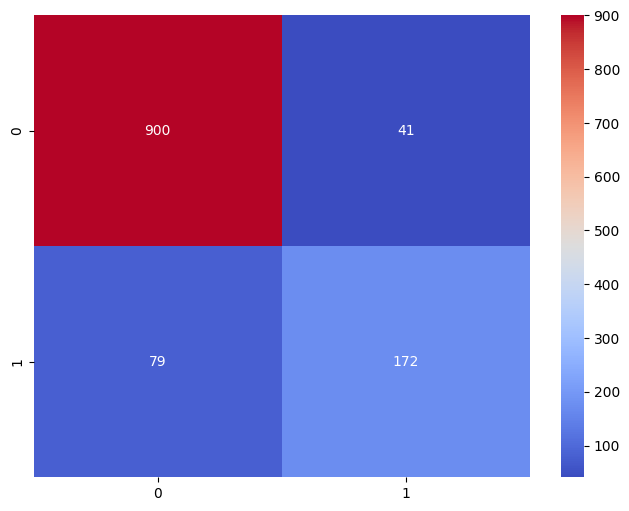

precision is 0.5521472392638037, recall is 0.7929515418502202, f1 is 0.650994575045208 Depth is 13
Recall Good: 0.8487046632124352, Recall Bad: 0.8487046632124352, Threshold: 0.17


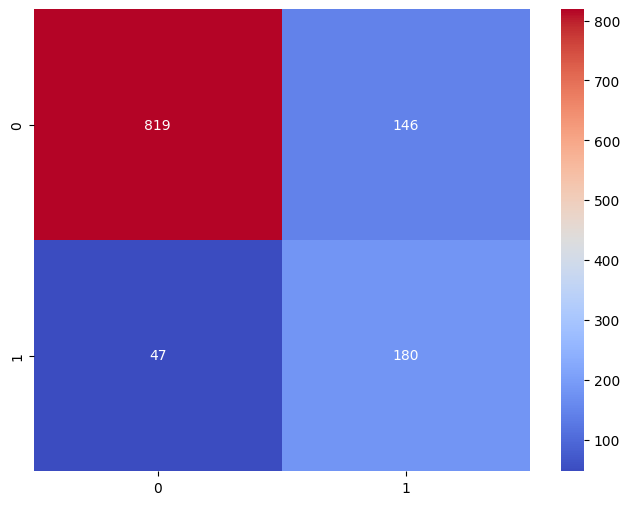

Mean precision error is 0.5992321798731084 Mean recall error is 0.7843660092717851  Mean f1 error is 0.6679973921537161 Mean Depth 14.4
Mean Recall Good: 0.8539998188096851 Mean Recall Bad: 0.7843660092717851 Mean Threshold 0.14800000000000002


In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)

precision_error = []
recall_error = []
f1_error = []
depth_track = []
threshold_track = []

recall_good_track = []
recall_bad_track = []


for train_idx, test_idx in kf.split(df):
    train_data = df.iloc[train_idx].copy()
    test_data = df.iloc[test_idx].copy()
    
    # Remove traget variable
    y_train = train_data.pop('BAD')
    y_test = test_data.pop('BAD')
    
    # Fill missing values with mean
    for col in mean_fill_cols:
        mean = train_data[col].mean()
        train_data[col] = train_data[col].fillna(mean)
        test_data[col] = test_data[col].fillna(mean)
    
    # Fill missing values using linear regression (It goes MORTDUE then VALUE as MORTDUE has more missing values)
    for col in lin_reg_cols:
        linear_train_data = train_data.copy()
        linear_test_data = test_data.copy()
        
        # fill VALUE with Mean for the first pass
        if col == 'MORTDUE':
            mean = linear_train_data['VALUE'].mean()
            linear_train_data['VALUE'] = linear_train_data['VALUE'].fillna(mean)
            linear_test_data['VALUE'] = linear_test_data['VALUE'].fillna(mean)
        
        linear_train_data = linear_train_data.dropna()
        
        # Set the scaling to be used
        standard_scaler_cols = ['LOAN', 'VALUE', 'CLAGE', 'CLNO', 'DEBTINC']
        min_max_scaler_cols = ['YOJ', 'DEROG', 'DELINQ', 'NINQ']
        one_hot = ['JOB', 'REASON']
        
        # Only the prediction column is not scaled
        if col in standard_scaler_cols:
            standard_scaler_cols.remove(col)
        
        if col in min_max_scaler_cols:
            min_max_scaler_cols.remove(col)
        
        # Create the process
        preprocessor = ColumnTransformer(
            transformers=[
                ('num_min_max', MinMaxScaler(), min_max_scaler_cols),
                ('num_standard', StandardScaler(), standard_scaler_cols),
                ('cat', OneHotEncoder(), one_hot)
            ]
        )
        # Remove traget variable
        y_linear_train = linear_train_data.pop(col)
        linear_test_data.pop(col)
        
        train_data_transformed = preprocessor.fit_transform(linear_train_data)
        test_data_transformed = preprocessor.transform(linear_test_data)
        
        # Create model
        linear_model = LinearRegression()
        linear_model.fit(train_data_transformed, y_linear_train)

        # Replace the missing values
        replacement_values = []
        
        for i, data in enumerate(test_data_transformed):
            
            if np.isnan(test_data.iloc[i][col]):
                replacement_values.append(linear_model.predict(data.reshape(1, -1))[0])
            else:
                replacement_values.append(test_data.iloc[i][col])
        test_data[col] = replacement_values
    
    
    # For one hot encoding
    passthrough_col = ['LOAN', 'VALUE', 'CLAGE', 'DEBTINC', 'DEROG', 'DELINQ', 'NINQ']
    one_hot = ['JOB', 'REASON']
    
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('passthrough', 'passthrough', passthrough_col),
            ('cat', OneHotEncoder(), one_hot)
        ]
    )
    
    
    train_data_transformed = preprocessor.fit_transform(train_data)
    test_data_transformed = preprocessor.transform(test_data)
    
    # Create model (Can play with class weights)
    tree_model = DecisionTreeClassifier(class_weight={0:1, 1:1}, random_state=8)
    tree_model.fit(train_data_transformed, y_train)
    
    # Prune Tree
    alpha_values = tree_model.cost_complexity_pruning_path(train_data_transformed, y_train).ccp_alphas
    tree_model = prune_tree(train_X=train_data_transformed, train_y=y_train, test_X=test_data_transformed, test_y=y_test, aplpha_values=alpha_values)
    
    y_prob = tree_model.predict_proba(train_data_transformed)[:, 1]
    
    threshold = get_best_threshold(y_true=y_train, y_prob=y_prob)
    threshold_track.append(threshold)
    
    y_prob = tree_model.predict_proba(test_data_transformed)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    
    # Get error
    print(f'precision is {precision_score(y_true=y_test, y_pred=y_pred)}, recall is {recall_score(y_true=y_test, y_pred=y_pred)}, f1 is {f1_score(y_true=y_test, y_pred=y_pred)} Depth is {tree_model.get_depth()}')
    precision_error.append(precision_score(y_true=y_test, y_pred=y_pred))
    recall_error.append(recall_score(y_true=y_test, y_pred=y_pred))
    f1_error.append(f1_score(y_true=y_test, y_pred=y_pred))
    depth_track.append(tree_model.get_depth())
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
    recall_bad = tp / (tp + fn)
    recall_good = tn / (tn + fp)
    
    recall_bad_track.append(recall_bad)
    recall_good_track.append(recall_good)
    
    print(f'Recall Good: {recall_good}, Recall Bad: {recall_good}, Threshold: {threshold}')
    
    
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), cmap='coolwarm', annot=True, fmt='d')
    plt.show()
    
    '''# Plot Tree
    feature_names = []
    
    for name in preprocessor.get_feature_names_out():
        feature_names.append(name.split('__')[1])
    
    plt.figure(figsize=(8, 6))
    plot_tree(tree_model, filled=True, feature_names=feature_names, max_depth=4)
    plt.savefig("tree.pdf", format="pdf")
    plt.show()'''

print(f'Mean precision error is {np.mean(precision_error)} Mean recall error is {np.mean(recall_error)}  Mean f1 error is {np.mean(f1_error)} Mean Depth {np.mean(depth_track)}')
print(f'Mean Recall Good: {np.mean(recall_good_track)} Mean Recall Bad: {np.mean(recall_bad_track)} Mean Threshold {np.mean(threshold_track)}')


# Objective Two

In [38]:
def get_best_threshold(y_true, y_prob):
    
    best_threshold = 0.5
    
    best_bad_recall = 0
    
    thresholds = np.arange(0.01, 1.0, 0.01)
    
    for threshold in thresholds:
        y_preds = (y_prob >= threshold).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
        
        recall_bad = tp / (tp + fn)
        recall_good = tn / (tn + fp)
        
        if recall_good >= 0.70 and recall_bad > best_bad_recall:
            best_bad_recall = recall_bad
            
            best_threshold = threshold
    
    return best_threshold

In [39]:
save_true = []
save_prob = []

precision is 0.49271844660194175, recall is 0.8565400843881856, f1 is 0.6255778120184899 Depth is 13
Recall Good: 0.7811518324607329, Recall Bad: 0.7811518324607329, Threshold: 0.08


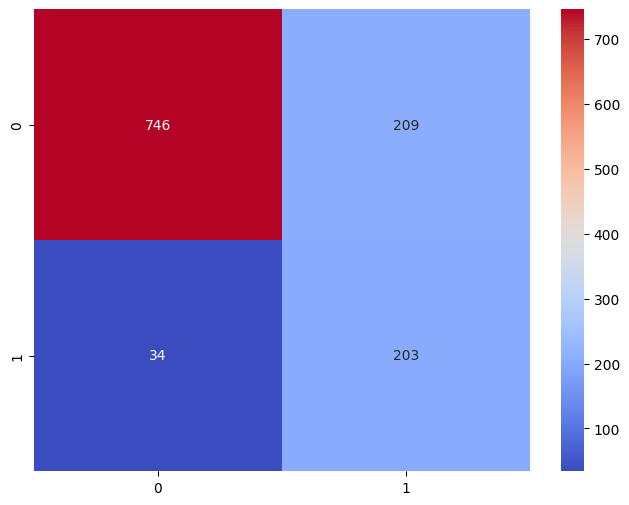

precision is 0.5036319612590799, recall is 0.8188976377952756, f1 is 0.623688155922039 Depth is 6
Recall Good: 0.7814498933901919, Recall Bad: 0.7814498933901919, Threshold: 0.060000000000000005


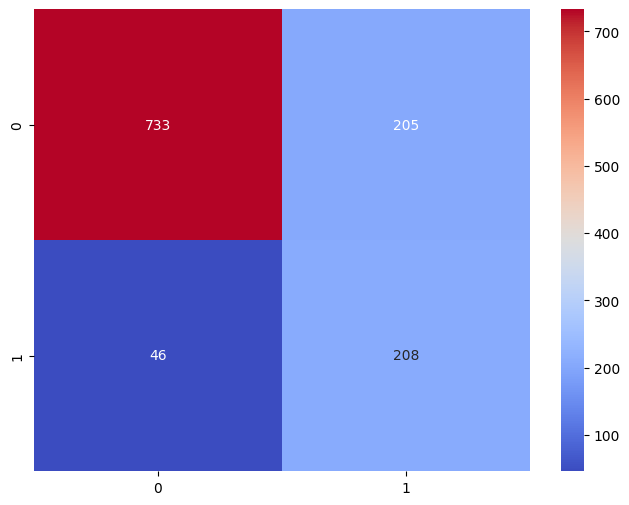

precision is 0.4748743718592965, recall is 0.8590909090909091, f1 is 0.6116504854368932 Depth is 18
Recall Good: 0.7849794238683128, Recall Bad: 0.7849794238683128, Threshold: 0.060000000000000005


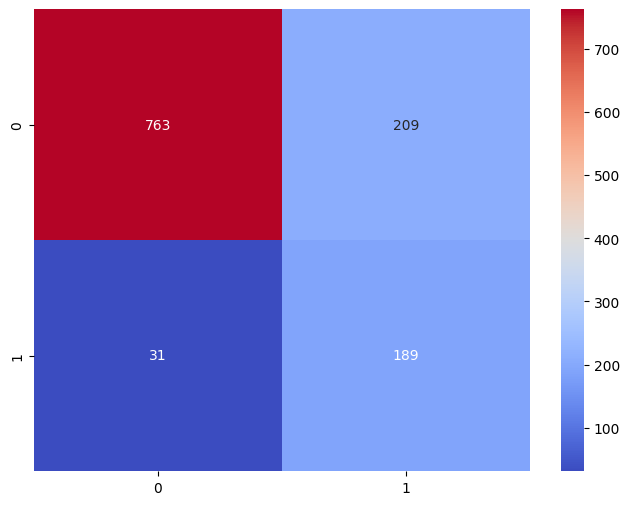

precision is 0.46021505376344085, recall is 0.852589641434263, f1 is 0.5977653631284916 Depth is 22
Recall Good: 0.7332624867162593, Recall Bad: 0.7332624867162593, Threshold: 0.03


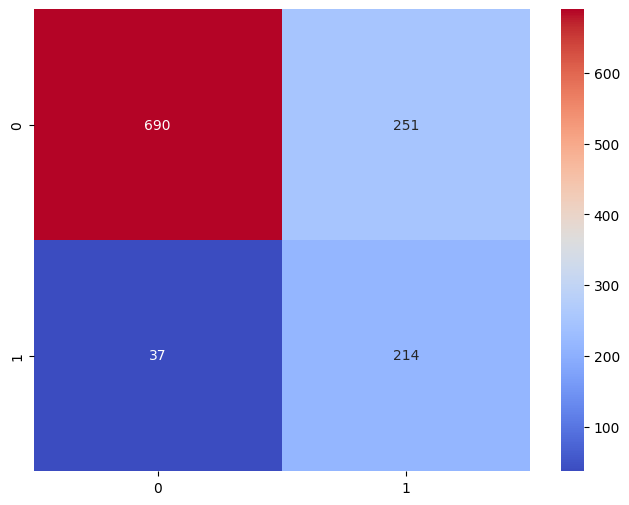

precision is 0.4413793103448276, recall is 0.8458149779735683, f1 is 0.5800604229607251 Depth is 13
Recall Good: 0.7481865284974093, Recall Bad: 0.7481865284974093, Threshold: 0.060000000000000005


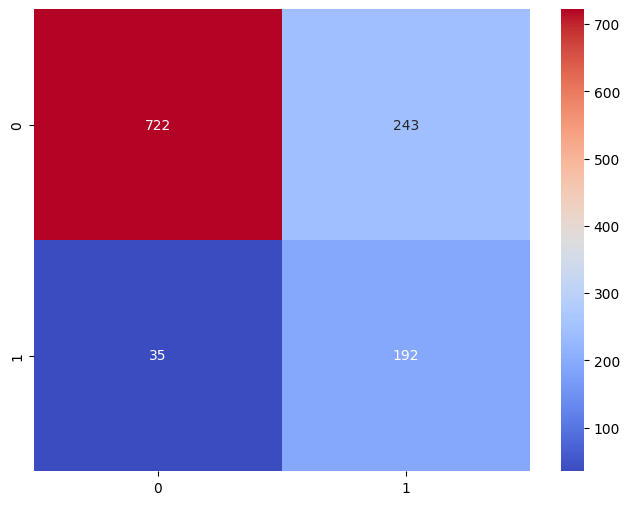

Mean precision error is 0.47456382876571734 Mean recall error is 0.8465866501364404  Mean f1 error is 0.6077484478933278 Mean Depth 14.4
Mean Recall Good: 0.7658060329865812 Mean Recall Bad: 0.8465866501364404 Mean Threshold 0.05800000000000001


In [40]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)

precision_error = []
recall_error = []
f1_error = []
depth_track = []
threshold_track = []

recall_good_track = []
recall_bad_track = []


for train_idx, test_idx in kf.split(df):
    train_data = df.iloc[train_idx].copy()
    test_data = df.iloc[test_idx].copy()
    
    # Remove traget variable
    y_train = train_data.pop('BAD')
    y_test = test_data.pop('BAD')
    
    # Fill missing values with mean
    for col in mean_fill_cols:
        mean = train_data[col].mean()
        train_data[col] = train_data[col].fillna(mean)
        test_data[col] = test_data[col].fillna(mean)
    
    # Fill missing values using linear regression (It goes MORTDUE then VALUE as MORTDUE has more missing values)
    for col in lin_reg_cols:
        linear_train_data = train_data.copy()
        linear_test_data = test_data.copy()
        
        # fill VALUE with Mean for the first pass
        if col == 'MORTDUE':
            mean = linear_train_data['VALUE'].mean()
            linear_train_data['VALUE'] = linear_train_data['VALUE'].fillna(mean)
            linear_test_data['VALUE'] = linear_test_data['VALUE'].fillna(mean)
        
        linear_train_data = linear_train_data.dropna()
        
        # Set the scaling to be used
        standard_scaler_cols = ['LOAN', 'VALUE', 'CLAGE', 'CLNO', 'DEBTINC']
        min_max_scaler_cols = ['YOJ', 'DEROG', 'DELINQ', 'NINQ']
        one_hot = ['JOB', 'REASON']
        
        # Only the prediction column is not scaled
        if col in standard_scaler_cols:
            standard_scaler_cols.remove(col)
        
        if col in min_max_scaler_cols:
            min_max_scaler_cols.remove(col)
        
        # Create the process
        preprocessor = ColumnTransformer(
            transformers=[
                ('num_min_max', MinMaxScaler(), min_max_scaler_cols),
                ('num_standard', StandardScaler(), standard_scaler_cols),
                ('cat', OneHotEncoder(), one_hot)
            ]
        )
        # Remove traget variable
        y_linear_train = linear_train_data.pop(col)
        linear_test_data.pop(col)
        
        train_data_transformed = preprocessor.fit_transform(linear_train_data)
        test_data_transformed = preprocessor.transform(linear_test_data)
        
        # Create model
        linear_model = LinearRegression()
        linear_model.fit(train_data_transformed, y_linear_train)

        # Replace the missing values
        replacement_values = []
        
        for i, data in enumerate(test_data_transformed):
            
            if np.isnan(test_data.iloc[i][col]):
                replacement_values.append(linear_model.predict(data.reshape(1, -1))[0])
            else:
                replacement_values.append(test_data.iloc[i][col])
        test_data[col] = replacement_values
    
    
    # For one hot encoding
    passthrough_col = ['LOAN', 'VALUE', 'CLAGE', 'DEBTINC', 'DEROG', 'DELINQ', 'NINQ']
    one_hot = ['JOB', 'REASON']
    
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('passthrough', 'passthrough', passthrough_col),
            ('cat', OneHotEncoder(), one_hot)
        ]
    )
    
    
    train_data_transformed = preprocessor.fit_transform(train_data)
    test_data_transformed = preprocessor.transform(test_data)
    
    # Create model (Can play with class weights)
    tree_model = DecisionTreeClassifier(class_weight={0:1, 1:1}, random_state=8)
    tree_model.fit(train_data_transformed, y_train)
    
    # Prune Tree
    alpha_values = tree_model.cost_complexity_pruning_path(train_data_transformed, y_train).ccp_alphas
    tree_model = prune_tree(train_X=train_data_transformed, train_y=y_train, test_X=test_data_transformed, test_y=y_test, aplpha_values=alpha_values)
    
    y_prob = tree_model.predict_proba(train_data_transformed)[:, 1]
    
    threshold = get_best_threshold(y_true=y_train, y_prob=y_prob)
    threshold_track.append(threshold)
    
    y_prob = tree_model.predict_proba(test_data_transformed)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    save_prob.append(y_prob)
    save_true.append(y_test)
    
    # Get error
    print(f'precision is {precision_score(y_true=y_test, y_pred=y_pred)}, recall is {recall_score(y_true=y_test, y_pred=y_pred)}, f1 is {f1_score(y_true=y_test, y_pred=y_pred)} Depth is {tree_model.get_depth()}')
    precision_error.append(precision_score(y_true=y_test, y_pred=y_pred))
    recall_error.append(recall_score(y_true=y_test, y_pred=y_pred))
    f1_error.append(f1_score(y_true=y_test, y_pred=y_pred))
    depth_track.append(tree_model.get_depth())
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
    recall_bad = tp / (tp + fn)
    recall_good = tn / (tn + fp)
    
    recall_bad_track.append(recall_bad)
    recall_good_track.append(recall_good)
    
    print(f'Recall Good: {recall_good}, Recall Bad: {recall_good}, Threshold: {threshold}')
    
    
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), cmap='coolwarm', annot=True, fmt='d')
    plt.show()
    
    '''# Plot Tree
    feature_names = []
    
    for name in preprocessor.get_feature_names_out():
        feature_names.append(name.split('__')[1])
    
    plt.figure(figsize=(8, 6))
    plot_tree(tree_model, filled=True, feature_names=feature_names, max_depth=4)
    plt.savefig("tree.pdf", format="pdf")
    plt.show()'''

print(f'Mean precision error is {np.mean(precision_error)} Mean recall error is {np.mean(recall_error)}  Mean f1 error is {np.mean(f1_error)} Mean Depth {np.mean(depth_track)}')
print(f'Mean Recall Good: {np.mean(recall_good_track)} Mean Recall Bad: {np.mean(recall_bad_track)} Mean Threshold {np.mean(threshold_track)}')


In [41]:
a = [item.values for item in save_true]

In [43]:
true_save_pred = []
for item in a:
    true_save_pred = true_save_pred + list(item)

In [44]:
true_save_prob = []
for item in save_prob:
    true_save_prob = true_save_prob + list(item)

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [53]:
fpr, tpr, thresholds = roc_curve(y_true=true_save_pred, y_score=true_save_prob)
roc_auc = auc(fpr, tpr)

<Figure size 640x480 with 0 Axes>

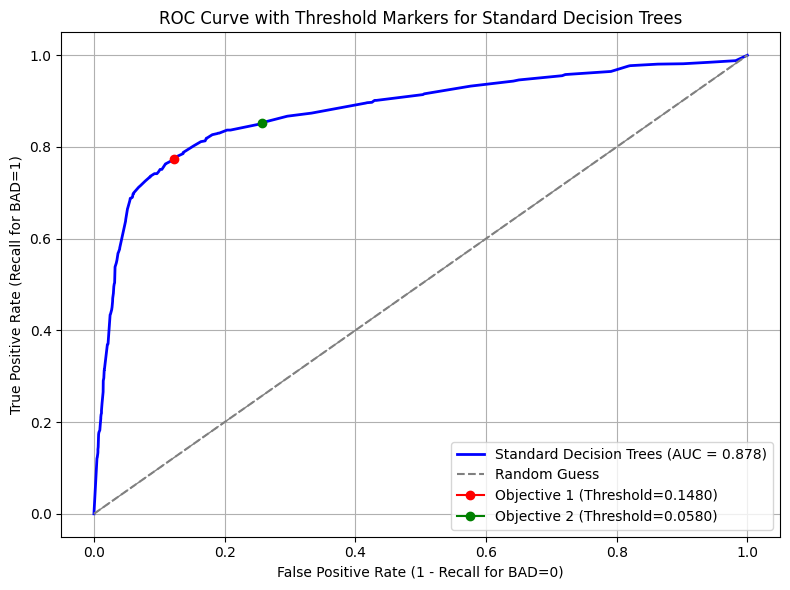

In [60]:
plt.figure()
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Standard Decision Trees (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

for label, t_value, color in [
        ("Objective 1", 0.148, "red"),
        ("Objective 2", 0.058, "green")
    ]:
        # Find index in roc_thresholds that is closest to the chosen threshold
        idx = np.argmin(np.abs(thresholds - t_value))
        plt.plot(fpr[idx], tpr[idx], marker='o', color=color, label=f'{label} (Threshold={t_value:.4f})')




plt.xlabel('False Positive Rate (1 - Recall for BAD=0)')
plt.ylabel('True Positive Rate (Recall for BAD=1)')
plt.title('ROC Curve with Threshold Markers for Standard Decision Trees')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('Graph.pdf', format='pdf')
plt.show()

In [49]:
print(roc_auc_score(y_true=true_save_pred, y_score=true_save_prob))

0.8784954798571901
